# 深層学習を用いた「オセロAI」_DQN

## ゲーム環境の実装
オセロのゲームを信仰させるためのクラスを作成する。盤面の状態、合法手の判定、石を置く処理を設定する

In [41]:

# セル1: ゲーム環境とランダムプレイヤー

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque, namedtuple
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- オセロのゲームクラス ---
class OthelloGame:
    def __init__(self, n=8):
        self.n = n
        self.board = np.zeros((n, n), dtype=int)
        mid = n // 2
        self.board[mid-1, mid-1] = self.board[mid, mid] = 1
        self.board[mid-1, mid] = self.board[mid, mid-1] = -1
        self.current_player = -1

    def get_board_state(self):
        """現在の盤面状態のコピーを返す"""
        return self.board.copy()

    def get_valid_moves(self, player):
        valid_moves = []
        for r in range(self.n):
            for c in range(self.n):
                if self.board[r, c] == 0:
                    for dr in [-1, 0, 1]:
                        for dc in [-1, 0, 1]:
                            if dr == 0 and dc == 0: continue
                            r_check, c_check, flipped = r + dr, c + dc, []
                            while 0 <= r_check < self.n and 0 <= c_check < self.n:
                                if self.board[r_check, c_check] == -player:
                                    flipped.append((r_check, c_check))
                                    r_check += dr
                                    c_check += dc
                                elif self.board[r_check, c_check] == player:
                                    if flipped: valid_moves.append((r, c))
                                    break
                                else: break
        return list(set(valid_moves))

    def make_move(self, move, player):
        r, c = move
        self.board[r, c] = player
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr == 0 and dc == 0: continue
                r_check, c_check, flipped = r + dr, c + dc, []
                while 0 <= r_check < self.n and 0 <= c_check < self.n:
                    if self.board[r_check, c_check] == -player:
                        flipped.append((r_check, c_check))
                        r_check += dr
                        c_check += dc
                    elif self.board[r_check, c_check] == player:
                        for fr, fc in flipped: self.board[fr, fc] = player
                        break
                    else: break

    def is_game_over(self):
        return not self.get_valid_moves(-1) and not self.get_valid_moves(1)

    def get_winner(self):
        black_stones = np.sum(self.board == -1)
        white_stones = np.sum(self.board == 1)
        if black_stones > white_stones: return -1
        elif white_stones > black_stones: return 1
        else: return 0

# --- 評価用のランダムプレイヤー ---
class RandomPlayer:
    def choose_action(self, valid_moves):
        return random.choice(valid_moves) if valid_moves else None

## DQNエージェントの実装
学習効率を高めるための、優先度付き経験再生バッファを実装。これはTD誤差（予測のズレ）が大きい「驚きのある経験」を優先的に学習するための仕組み。
次に強化学習でオセロを学習エージェントを作成する。盤面を画像のようにとらえて判断するCNNをモデルとして使用。

In [42]:
# セル2: 優先度付き経験再生 (PER) のためのSumTree
class SumTree:
    """
    PERで優先度付きサンプリングを効率的に行うためのデータ構造
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0
        self.write = 0

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2
        self.tree[parent] += change
        if parent != 0: self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1
        if left >= len(self.tree): return idx
        if s <= self.tree[left]: return self._retrieve(left, s)
        else: return self._retrieve(right, s - self.tree[left])

    def total(self): return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, p)
        self.write += 1
        if self.write >= self.capacity: self.write = 0
        if self.n_entries < self.capacity: self.n_entries += 1

    def update(self, idx, p):
        change = p - self.tree[idx]
        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1
        return (idx, self.tree[idx], self.data[dataIdx])

class PERBuffer:
    """優先度付き経験再生バッファ"""
    def __init__(self, capacity, a=0.6, b=0.4, b_increment=0.001):
        self.tree = SumTree(capacity)
        self.a = a; self.b = b; self.b_increment = b_increment
        self.e = 0.01; self.max_p = 1.0

    def add(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.tree.add(self.max_p, experience)

    def sample(self, n):
        batch = []; idxs = []; priorities = []
        segment = self.tree.total() / n
        self.b = np.min([1., self.b + self.b_increment])

        for i in range(n):
            a = segment * i; b = segment * (i + 1)
            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            if not isinstance(data, int): # データが存在する場合のみ追加
                priorities.append(p); batch.append(data); idxs.append(idx)

        sampling_probabilities = np.array(priorities) / self.tree.total()
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.b)
        is_weight /= is_weight.max()

        return batch, idxs, is_weight

    def update(self, idx, error):
        p = (np.abs(error) + self.e) ** self.a
        self.max_p = max(self.max_p, p)
        self.tree.update(idx, p)

    def __len__(self):
        return self.tree.n_entries

In [43]:
# セル3: 高機能DQNエージェント (Double DQN + PER)

class QNetwork(nn.Module):
    """盤面を入力とし、各マスのQ値を出力するニューラルネットワーク"""
    def __init__(self, n=8):
        super(QNetwork, self).__init__(); self.n = n
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * n * n, 256)
        self.fc2 = nn.Linear(256, n * n)
    def forward(self, x):
        x = x.view(-1, 1, self.n, self.n); x = F.relu(self.conv1(x)); x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1); x = F.relu(self.fc1(x)); x = self.fc2(x)
        return x

class AdvancedDQNAgent:
    """Double DQNとPERを実装したAIエージェント"""
    def __init__(self, n, args, device='cpu'):
        self.n = n; self.args = args; self.device = device

        self.q_network = QNetwork(n).to(device)
        self.target_network = QNetwork(n).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=args['lr'])
        self.memory = PERBuffer(args['memory_size']) if args['use_per'] else deque(maxlen=args['memory_size'])

        self.epsilon = args['epsilon_start']
        self.epsilon_decay = args['epsilon_decay']
        self.epsilon_min = args['epsilon_min']
        self.gamma = args['gamma']

    def choose_action(self, state, valid_moves, player):
        if not valid_moves: return None
        if random.random() < self.epsilon:
            return random.choice(valid_moves)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state * player).unsqueeze(0).to(self.device)
                q_values = self.q_network(state_tensor).squeeze(0)
                valid_q = {m: q_values[m[0] * self.n + m[1]] for m in valid_moves}
                return max(valid_q, key=valid_q.get)

    def store_transition(self, state, action, reward, next_state, done):
        if self.args['use_per']: self.memory.add(state, action, reward, next_state, done)
        else: self.memory.append((state, action, reward, next_state, done))

    def learn(self, batch_size):
        if len(self.memory) < batch_size: return

        if self.args['use_per']:
            transitions, idxs, is_weights = self.memory.sample(batch_size)
            if not transitions: return # サンプルが空の場合は学習しない
            is_weights = torch.FloatTensor(is_weights).to(self.device)
        else:
            transitions = random.sample(self.memory, batch_size)

        states, actions, rewards, next_states, dones = zip(*transitions)
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor([a[0] * self.n + a[1] for a in actions]).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        current_q = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # --- Double DQN ---
        next_actions = self.q_network(next_states).max(1)[1].unsqueeze(1)
        next_q_values = self.target_network(next_states).gather(1, next_actions).squeeze(1)
        target_q = rewards + self.gamma * next_q_values * (1 - dones)

        errors = torch.abs(current_q - target_q.detach()).detach().cpu().numpy()

        # --- PERの重み更新と損失計算 ---
        if self.args['use_per']:
            for i in range(len(idxs)): self.memory.update(idxs[i], errors[i])
            loss = (is_weights * F.mse_loss(current_q, target_q.detach(), reduction='none')).mean()
        else:
            loss = F.mse_loss(current_q, target_q.detach())

        self.optimizer.zero_grad(); loss.backward(); self.optimizer.step()
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())


##学習と評価の実行

In [44]:
# セル4: 学習と評価の実行

def evaluate_agent(agent, num_games=50):
    """指定されたエージェントとランダムプレイヤーを対戦させて勝率を評価する"""
    wins = 0
    for _ in range(num_games):
        game = OthelloGame()
        random_player = RandomPlayer()
        agent_player = -1 # エージェントは黒番（先手）

        while not game.is_game_over():
            player = game.current_player
            valid_moves = game.get_valid_moves(player)
            if not valid_moves:
                game.current_player *= -1
                continue

            if player == agent_player:
                action = agent.choose_action(game.get_board_state(), valid_moves, player)
            else:
                action = random_player.choose_action(valid_moves)

            if action: game.make_move(action, player)
            game.current_player *= -1

        if game.get_winner() == agent_player: wins += 1
    return wins / num_games

def run_training(args):
    """指定された設定でDQNエージェントの学習を実行する"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    agent = AdvancedDQNAgent(n=8, args=args, device=device)
    history = {'episode': [], 'win_rate': []}

    print(f"\n--- 学習開始: {args['model_name']} ---")
    print(f"デバイス: {device}")

    for e in tqdm(range(args['episodes']), desc=f"学習中 ({args['model_name']})"):
        game = OthelloGame()
        state = game.get_board_state()  # メソッド呼び出しに修正
        done = False

        while not done:
            player = game.current_player
            valid_moves = game.get_valid_moves(player)
            if not valid_moves:
                game.current_player *= -1
                if not game.get_valid_moves(game.current_player): done = True
                continue

            action = agent.choose_action(state, valid_moves, player)
            if action:
                game.make_move(action, player)
                next_state = game.get_board_state()  # メソッド呼び出しに修正
                done = game.is_game_over()
                reward = game.get_winner() * player if done else 0
                agent.store_transition(state * player, action, reward, next_state * player, done)
                state = next_state

            game.current_player *= -1

        if len(agent.memory) > args['batch_size']:
            agent.learn(args['batch_size'])

        if (e + 1) % args['target_update'] == 0:
            agent.update_target_network()

        if (e + 1) % args['eval_interval'] == 0:
            # 探索率を評価時は一時的に0にする
            original_epsilon = agent.epsilon
            agent.epsilon = 0
            win_rate = evaluate_agent(agent)
            agent.epsilon = original_epsilon # 元に戻す

            history['episode'].append(e + 1)
            history['win_rate'].append(win_rate)
            print(f"エピソード {e+1}: ランダム対戦勝率: {win_rate:.2%}, イプシロン: {agent.epsilon:.4f}")

    return history

# --- パラメータ設定 ---
# ベースDQNモデル (DQN + 標準リプレイ)
args_base = {
    'model_name': 'ベースDQN',
    'lr': 0.001, 'gamma': 0.99, 'memory_size': 10000, 'batch_size': 64,
    'epsilon_start': 1.0, 'epsilon_decay': 0.999, 'epsilon_min': 0.01,
    'target_update': 10, 'episodes': 10000, 'eval_interval': 500, 'use_per': False
}
# 高機能DQNモデル (Double DQN + PER + 再調整)
args_advanced = {
    'model_name': '高機能DQN',
    'lr': 0.0005, 'gamma': 0.99, 'memory_size': 20000, 'batch_size': 64,
    'epsilon_start': 1.0, 'epsilon_decay': 0.9999, 'epsilon_min': 0.1,
    'target_update': 10, 'episodes': 10000, 'eval_interval': 500, 'use_per': True
}

# --- 学習実行 ---
history_base = run_training(args_base)
history_advanced = run_training(args_advanced)


--- 学習開始: ベースDQN ---
デバイス: cuda


学習中 (ベースDQN):   5%|▌         | 504/10000 [00:17<24:41,  6.41it/s]

エピソード 500: ランダム対戦勝率: 52.00%, イプシロン: 0.6070


学習中 (ベースDQN):  10%|█         | 1003/10000 [00:41<25:52,  5.80it/s]

エピソード 1000: ランダム対戦勝率: 24.00%, イプシロン: 0.3681


学習中 (ベースDQN):  15%|█▌        | 1503/10000 [01:08<30:54,  4.58it/s]

エピソード 1500: ランダム対戦勝率: 14.00%, イプシロン: 0.2232


学習中 (ベースDQN):  20%|██        | 2003/10000 [01:39<32:29,  4.10it/s]

エピソード 2000: ランダム対戦勝率: 8.00%, イプシロン: 0.1353


学習中 (ベースDQN):  25%|██▌       | 2503/10000 [02:09<29:50,  4.19it/s]

エピソード 2500: ランダム対戦勝率: 12.00%, イプシロン: 0.0821


学習中 (ベースDQN):  30%|███       | 3003/10000 [02:41<27:56,  4.17it/s]

エピソード 3000: ランダム対戦勝率: 12.00%, イプシロン: 0.0498


学習中 (ベースDQN):  35%|███▌      | 3501/10000 [03:13<42:09,  2.57it/s]

エピソード 3500: ランダム対戦勝率: 22.00%, イプシロン: 0.0302


学習中 (ベースDQN):  40%|████      | 4003/10000 [03:45<23:26,  4.26it/s]

エピソード 4000: ランダム対戦勝率: 16.00%, イプシロン: 0.0183


学習中 (ベースDQN):  45%|████▌     | 4503/10000 [04:18<21:38,  4.23it/s]

エピソード 4500: ランダム対戦勝率: 14.00%, イプシロン: 0.0111


学習中 (ベースDQN):  50%|█████     | 5001/10000 [04:50<29:43,  2.80it/s]

エピソード 5000: ランダム対戦勝率: 14.00%, イプシロン: 0.0100


学習中 (ベースDQN):  55%|█████▌    | 5503/10000 [05:22<17:35,  4.26it/s]

エピソード 5500: ランダム対戦勝率: 12.00%, イプシロン: 0.0100


学習中 (ベースDQN):  60%|██████    | 6003/10000 [05:55<15:24,  4.32it/s]

エピソード 6000: ランダム対戦勝率: 20.00%, イプシロン: 0.0100


学習中 (ベースDQN):  65%|██████▌   | 6503/10000 [06:26<13:32,  4.31it/s]

エピソード 6500: ランダム対戦勝率: 8.00%, イプシロン: 0.0100


学習中 (ベースDQN):  70%|███████   | 7003/10000 [06:58<11:32,  4.33it/s]

エピソード 7000: ランダム対戦勝率: 6.00%, イプシロン: 0.0100


学習中 (ベースDQN):  75%|███████▌  | 7503/10000 [07:30<12:08,  3.43it/s]

エピソード 7500: ランダム対戦勝率: 16.00%, イプシロン: 0.0100


学習中 (ベースDQN):  80%|████████  | 8003/10000 [08:02<07:59,  4.17it/s]

エピソード 8000: ランダム対戦勝率: 10.00%, イプシロン: 0.0100


学習中 (ベースDQN):  85%|████████▌ | 8503/10000 [08:35<06:07,  4.08it/s]

エピソード 8500: ランダム対戦勝率: 8.00%, イプシロン: 0.0100


学習中 (ベースDQN):  90%|█████████ | 9003/10000 [09:08<05:03,  3.29it/s]

エピソード 9000: ランダム対戦勝率: 10.00%, イプシロン: 0.0100


学習中 (ベースDQN):  95%|█████████▌| 9503/10000 [09:39<01:55,  4.29it/s]

エピソード 9500: ランダム対戦勝率: 14.00%, イプシロン: 0.0100


学習中 (ベースDQN): 100%|██████████| 10000/10000 [10:12<00:00, 16.34it/s]


エピソード 10000: ランダム対戦勝率: 10.00%, イプシロン: 0.0100

--- 学習開始: 高機能DQN ---
デバイス: cuda


学習中 (高機能DQN):   5%|▌         | 505/10000 [00:14<14:52, 10.64it/s]

エピソード 500: ランダム対戦勝率: 22.00%, イプシロン: 0.9513


学習中 (高機能DQN):  10%|█         | 1005/10000 [00:29<16:56,  8.85it/s]

エピソード 1000: ランダム対戦勝率: 72.00%, イプシロン: 0.9049


学習中 (高機能DQN):  15%|█▌        | 1505/10000 [00:45<23:03,  6.14it/s]

エピソード 1500: ランダム対戦勝率: 78.00%, イプシロン: 0.8608


学習中 (高機能DQN):  20%|██        | 2005/10000 [01:02<16:07,  8.26it/s]

エピソード 2000: ランダム対戦勝率: 72.00%, イプシロン: 0.8188


学習中 (高機能DQN):  25%|██▌       | 2503/10000 [01:20<22:33,  5.54it/s]

エピソード 2500: ランダム対戦勝率: 66.00%, イプシロン: 0.7789


学習中 (高機能DQN):  30%|███       | 3004/10000 [01:39<14:31,  8.03it/s]

エピソード 3000: ランダム対戦勝率: 76.00%, イプシロン: 0.7409


学習中 (高機能DQN):  35%|███▌      | 3503/10000 [01:59<20:28,  5.29it/s]

エピソード 3500: ランダム対戦勝率: 72.00%, イプシロン: 0.7047


学習中 (高機能DQN):  40%|████      | 4003/10000 [02:18<15:50,  6.31it/s]

エピソード 4000: ランダム対戦勝率: 74.00%, イプシロン: 0.6704


学習中 (高機能DQN):  45%|████▌     | 4504/10000 [02:40<13:57,  6.56it/s]

エピソード 4500: ランダム対戦勝率: 74.00%, イプシロン: 0.6377


学習中 (高機能DQN):  50%|█████     | 5003/10000 [03:01<13:31,  6.15it/s]

エピソード 5000: ランダム対戦勝率: 62.00%, イプシロン: 0.6066


学習中 (高機能DQN):  55%|█████▌    | 5504/10000 [03:24<15:58,  4.69it/s]

エピソード 5500: ランダム対戦勝率: 56.00%, イプシロン: 0.5770


学習中 (高機能DQN):  60%|██████    | 6002/10000 [03:46<13:49,  4.82it/s]

エピソード 6000: ランダム対戦勝率: 56.00%, イプシロン: 0.5489


学習中 (高機能DQN):  65%|██████▌   | 6505/10000 [04:10<09:05,  6.41it/s]

エピソード 6500: ランダム対戦勝率: 60.00%, イプシロン: 0.5221


学習中 (高機能DQN):  70%|███████   | 7004/10000 [04:33<08:03,  6.19it/s]

エピソード 7000: ランダム対戦勝率: 42.00%, イプシロン: 0.4966


学習中 (高機能DQN):  75%|███████▌  | 7504/10000 [04:58<06:51,  6.07it/s]

エピソード 7500: ランダム対戦勝率: 80.00%, イプシロン: 0.4724


学習中 (高機能DQN):  80%|████████  | 8004/10000 [05:22<05:20,  6.22it/s]

エピソード 8000: ランダム対戦勝率: 24.00%, イプシロン: 0.4494


学習中 (高機能DQN):  85%|████████▌ | 8503/10000 [05:48<04:54,  5.08it/s]

エピソード 8500: ランダム対戦勝率: 50.00%, イプシロン: 0.4274


学習中 (高機能DQN):  90%|█████████ | 9002/10000 [06:14<04:48,  3.46it/s]

エピソード 9000: ランダム対戦勝率: 28.00%, イプシロン: 0.4066


学習中 (高機能DQN):  95%|█████████▌| 9503/10000 [06:40<01:59,  4.15it/s]

エピソード 9500: ランダム対戦勝率: 38.00%, イプシロン: 0.3868


学習中 (高機能DQN): 100%|██████████| 10000/10000 [07:06<00:00, 23.43it/s]

エピソード 10000: ランダム対戦勝率: 62.00%, イプシロン: 0.3679


In [45]:
# セル5: モデルの保存と読み込み
def save_model(agent, filepath):
    """学習済みモデルを保存"""
    torch.save({
        'model_state_dict': agent.q_network.state_dict(),
        'target_state_dict': agent.target_network.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
        'epsilon': agent.epsilon,
        'args': agent.args
    }, filepath)
    print(f"モデルを {filepath} に保存しました")

def load_model(filepath, device='cpu'):
    """保存されたモデルを読み込み"""
    checkpoint = torch.load(filepath, map_location=device)

    # エージェントを再作成
    agent = AdvancedDQNAgent(n=8, args=checkpoint['args'], device=device)

    # 状態を復元
    agent.q_network.load_state_dict(checkpoint['model_state_dict'])
    agent.target_network.load_state_dict(checkpoint['target_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    agent.epsilon = checkpoint['epsilon']

    print(f"モデルを {filepath} から読み込みました")
    return agent

# 高機能DQNモデルを保存
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
advanced_agent = AdvancedDQNAgent(n=8, args=args_advanced, device=device)

# 学習済みの重みを持つエージェントを作成（実際の学習後の状態を再現）

def run_training_with_agent_return(args):
    """指定された設定でDQNエージェントの学習を実行し、エージェントも返す"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    agent = AdvancedDQNAgent(n=8, args=args, device=device)
    history = {'episode': [], 'win_rate': []}

    print(f"\n--- 学習開始: {args['model_name']} ---")
    print(f"デバイス: {device}")

    for e in tqdm(range(args['episodes']), desc=f"学習中 ({args['model_name']})"):
        game = OthelloGame()
        state = game.get_board_state()
        done = False

        while not done:
            player = game.current_player
            valid_moves = game.get_valid_moves(player)
            if not valid_moves:
                game.current_player *= -1
                if not game.get_valid_moves(game.current_player): done = True
                continue

            action = agent.choose_action(state, valid_moves, player)
            if action:
                game.make_move(action, player)
                next_state = game.get_board_state()
                done = game.is_game_over()
                reward = game.get_winner() * player if done else 0
                agent.store_transition(state * player, action, reward, next_state * player, done)
                state = next_state

            game.current_player *= -1

        if len(agent.memory) > args['batch_size']:
            agent.learn(args['batch_size'])

        if (e + 1) % args['target_update'] == 0:
            agent.update_target_network()

        if (e + 1) % args['eval_interval'] == 0:
            original_epsilon = agent.epsilon
            agent.epsilon = 0
            win_rate = evaluate_agent(agent)
            agent.epsilon = original_epsilon

            history['episode'].append(e + 1)
            history['win_rate'].append(win_rate)
            print(f"エピソード {e+1}: ランダム対戦勝率: {win_rate:.2%}, イプシロン: {agent.epsilon:.4f}")

    return history, agent

# 高機能DQNの学習を実行してエージェントを取得
print("高機能DQNの学習を開始します...")
history_advanced_new, trained_agent = run_training_with_agent_return(args_advanced)

# 学習済みモデルを保存
save_model(trained_agent, 'advanced_dqn.pth')

# モデルの読み込みテスト
print("\n保存したモデルを読み込んでテストします...")
loaded_agent = load_model('advanced_dqn.pth', device=device)

# 読み込んだモデルの性能を評価
loaded_agent.epsilon = 0  # 評価時は探索しない
test_win_rate = evaluate_agent(loaded_agent, num_games=100)
print(f"読み込んだモデルのテスト勝率: {test_win_rate:.2%}")

高機能DQNの学習を開始します...

--- 学習開始: 高機能DQN ---
デバイス: cuda


学習中 (高機能DQN):   5%|▌         | 506/10000 [00:14<15:00, 10.54it/s]

エピソード 500: ランダム対戦勝率: 40.00%, イプシロン: 0.9513


学習中 (高機能DQN):  10%|█         | 1007/10000 [00:28<15:46,  9.50it/s]

エピソード 1000: ランダム対戦勝率: 40.00%, イプシロン: 0.9049


学習中 (高機能DQN):  15%|█▌        | 1505/10000 [00:45<22:28,  6.30it/s]

エピソード 1500: ランダム対戦勝率: 46.00%, イプシロン: 0.8608


学習中 (高機能DQN):  20%|██        | 2005/10000 [01:02<15:59,  8.33it/s]

エピソード 2000: ランダム対戦勝率: 44.00%, イプシロン: 0.8188


学習中 (高機能DQN):  25%|██▌       | 2503/10000 [01:19<20:55,  5.97it/s]

エピソード 2500: ランダム対戦勝率: 48.00%, イプシロン: 0.7789


学習中 (高機能DQN):  30%|███       | 3003/10000 [01:38<18:46,  6.21it/s]

エピソード 3000: ランダム対戦勝率: 58.00%, イプシロン: 0.7409


学習中 (高機能DQN):  35%|███▌      | 3503/10000 [01:58<19:55,  5.44it/s]

エピソード 3500: ランダム対戦勝率: 70.00%, イプシロン: 0.7047


学習中 (高機能DQN):  40%|████      | 4005/10000 [02:17<15:34,  6.41it/s]

エピソード 4000: ランダム対戦勝率: 54.00%, イプシロン: 0.6704


学習中 (高機能DQN):  45%|████▌     | 4505/10000 [02:38<14:24,  6.35it/s]

エピソード 4500: ランダム対戦勝率: 52.00%, イプシロン: 0.6377


学習中 (高機能DQN):  50%|█████     | 5004/10000 [03:00<18:18,  4.55it/s]

エピソード 5000: ランダム対戦勝率: 52.00%, イプシロン: 0.6066


学習中 (高機能DQN):  55%|█████▌    | 5502/10000 [03:22<19:31,  3.84it/s]

エピソード 5500: ランダム対戦勝率: 42.00%, イプシロン: 0.5770


学習中 (高機能DQN):  60%|██████    | 6003/10000 [03:44<10:47,  6.18it/s]

エピソード 6000: ランダム対戦勝率: 32.00%, イプシロン: 0.5489


学習中 (高機能DQN):  65%|██████▌   | 6505/10000 [04:08<09:21,  6.23it/s]

エピソード 6500: ランダム対戦勝率: 34.00%, イプシロン: 0.5221


学習中 (高機能DQN):  70%|███████   | 7003/10000 [04:32<08:12,  6.09it/s]

エピソード 7000: ランダム対戦勝率: 22.00%, イプシロン: 0.4966


学習中 (高機能DQN):  75%|███████▌  | 7503/10000 [04:56<07:29,  5.55it/s]

エピソード 7500: ランダム対戦勝率: 54.00%, イプシロン: 0.4724


学習中 (高機能DQN):  80%|████████  | 8004/10000 [05:21<05:28,  6.08it/s]

エピソード 8000: ランダム対戦勝率: 34.00%, イプシロン: 0.4494


学習中 (高機能DQN):  85%|████████▌ | 8503/10000 [05:47<04:08,  6.03it/s]

エピソード 8500: ランダム対戦勝率: 68.00%, イプシロン: 0.4274


学習中 (高機能DQN):  90%|█████████ | 9002/10000 [06:14<04:55,  3.38it/s]

エピソード 9000: ランダム対戦勝率: 40.00%, イプシロン: 0.4066


学習中 (高機能DQN):  95%|█████████▌| 9503/10000 [06:40<01:46,  4.65it/s]

エピソード 9500: ランダム対戦勝率: 46.00%, イプシロン: 0.3868


学習中 (高機能DQN): 100%|██████████| 10000/10000 [07:07<00:00, 23.42it/s]

エピソード 10000: ランダム対戦勝率: 40.00%, イプシロン: 0.3679
モデルを advanced_dqn.pth に保存しました

保存したモデルを読み込んでテストします...
モデルを advanced_dqn.pth から読み込みました


読み込んだモデルのテスト勝率: 41.00%


## 性能比較の可視化

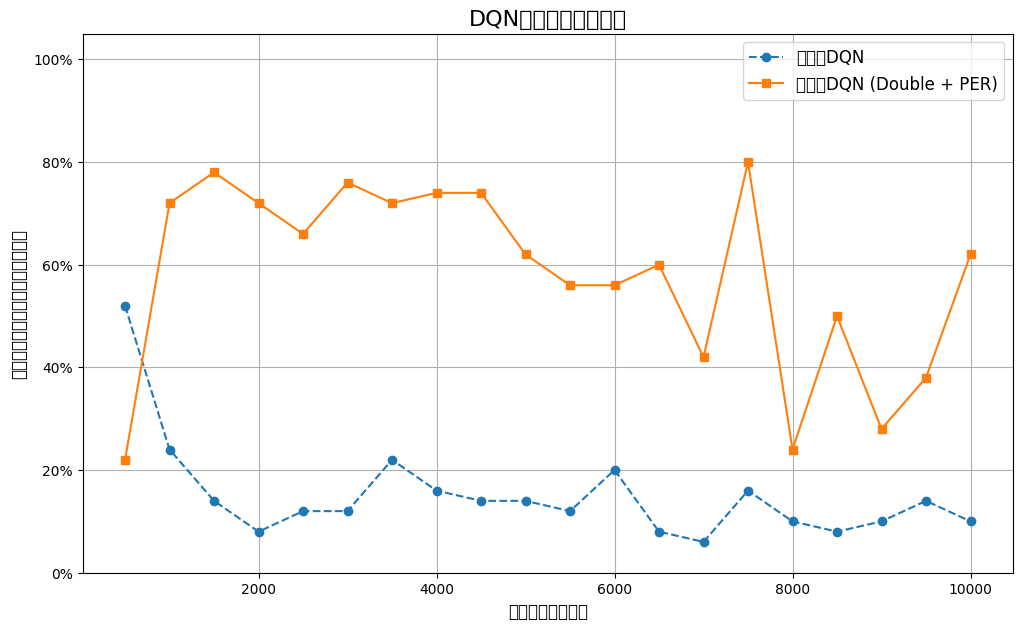

In [46]:
# セル6: 性能比較の可視化
plt.figure(figsize=(12, 7))
plt.plot(history_base['episode'], history_base['win_rate'], marker='o', linestyle='--', label='ベースDQN')
plt.plot(history_advanced['episode'], history_advanced['win_rate'], marker='s', linestyle='-', label='高機能DQN (Double + PER)')

plt.title('DQNモデルの性能比較', fontsize=16)
plt.xlabel('学習エピソード数', fontsize=12)
plt.ylabel('ランダムプレイヤーに対する勝率', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format)) # Y軸をパーセント表示に
plt.ylim(0, 1.05)
plt.show()